In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, lqr
import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.005
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [21]:
def _actor_initial_weight(actor):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.01]])
    
    K = lqr(A,B,Q,R)[0]
    
    weights = []
    for i in range(len(actor.layers)):
        if i < 2:
            continue
        else:
            w, b = actor.layers[i].get_weights()
            w, b = np.zeros_like(w), np.zeros_like(b)
            if i == 2:
                w[0][0] = K[0]
                w[1][0] = K[1]
            elif i == 4:
                w[0][0] = 1
                w[1][1] = 1
            else:
                w[0][0] = 1
            weights.append(w)
            weights.append(b)
    return weights

def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="single_lin_relu")(x)
    x = Dense(16, activation="single_lin_relu_sig")(x)
    x = Dense(3, activation="single_lin_tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    actor.summary()
    actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [22]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [23]:
#safe learning
l = 0.5
step = 300000
episode_step = int(200 * 0.05 / dt)
time_mode = False
a = agent((3,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, loss_graph=0, time_mode=time_mode, pure=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1, 2)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_20 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 51        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
Training for 300000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 43s 4ms/step - reward: -0.2490
5 epi

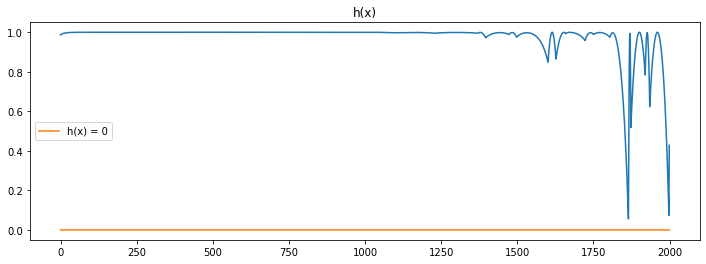

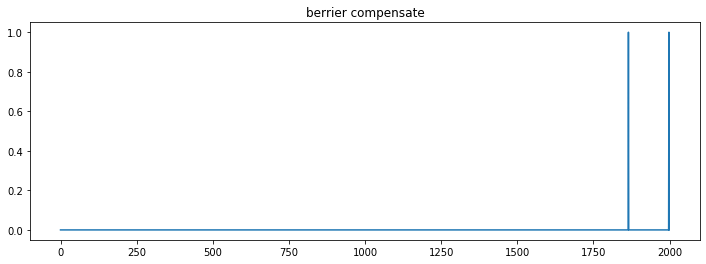

In [33]:
# first episode log
episode_step = int(200 * 0.05 / dt)
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[:episode_step,0])
plt.plot(range(episode_step), np.zeros(episode_step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[:episode_step,1])
plt.show()

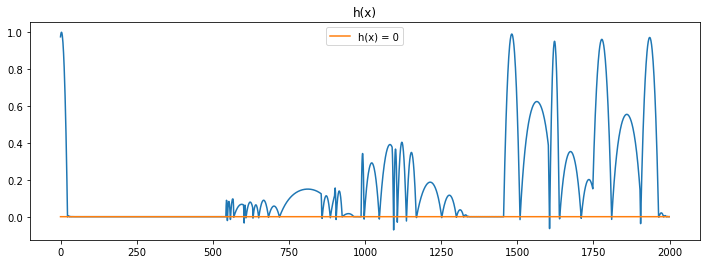

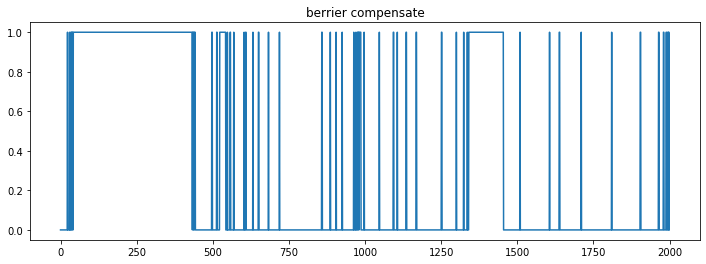

In [6]:
# log per episode
interval = 10
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1), 0])
plt.plot(range(episode_step), np.zeros(episode_step ,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(episode_step), a.cbf_log[episode_step * interval : episode_step * (interval+1),1])
plt.show()

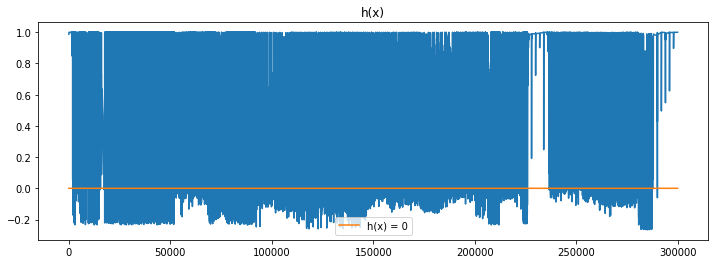

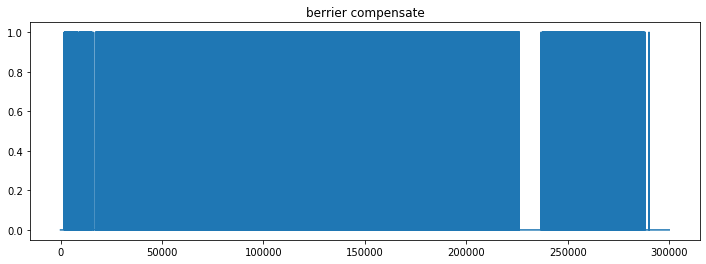

In [24]:
# log throughout learning
plt.figure(figsize=(12,4))
plt.title('h(x)')
plt.plot(range(step), a.cbf_log[:,0])
plt.plot(range(step), np.zeros(step,), label='h(x) = 0')
#plt.ylim(-10,1)
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.plot(range(step), a.cbf_log[:,1])
plt.show()

In [34]:
# a.load_weights('../learned_models_safe/3000000_e2000_l05_pure.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=episode_step, action_view=1, time_mode=time_mode, pure=1)

Testing for 1 episodes ...
step =  1 , output of actor network =  [-8.543732 -1.        1.      ]
step =  2 , output of actor network =  [-5.3141203 -1.         1.       ]
step =  3 , output of actor network =  [-2.0812554  -0.99998236  0.99872035]
step =  4 , output of actor network =  [ 1.0422037  1.        -0.9999814]
step =  5 , output of actor network =  [ 0.7713111  1.        -0.999898 ]
step =  6 , output of actor network =  [ 0.5731084   1.         -0.99964917]
step =  7 , output of actor network =  [ 0.4289294   1.         -0.99914193]
step =  8 , output of actor network =  [ 0.32445157  1.         -0.9983631 ]
step =  9 , output of actor network =  [ 0.24892074  0.99999994 -0.99739295]
step =  10 , output of actor network =  [ 0.19438481  0.9999999  -0.9963541 ]
step =  11 , output of actor network =  [ 0.15501899  0.9999999  -0.9953576 ]
step =  12 , output of actor network =  [ 0.12658626  0.9999998  -0.99447364]
step =  13 , output of actor network =  [ 0.10602039  0.99999

step =  158 , output of actor network =  [ 0.0316689   0.99999905 -0.9901274 ]
step =  159 , output of actor network =  [ 0.03165609  0.99999905 -0.99012655]
step =  160 , output of actor network =  [ 0.03164333  0.99999917 -0.99012583]
step =  161 , output of actor network =  [ 0.03163093  0.99999905 -0.99012506]
step =  162 , output of actor network =  [ 0.03161925  0.99999905 -0.9901244 ]
step =  163 , output of actor network =  [ 0.03160757  0.99999905 -0.9901237 ]
step =  164 , output of actor network =  [ 0.03159636  0.99999905 -0.9901231 ]
step =  165 , output of actor network =  [ 0.03158534  0.99999905 -0.9901224 ]
step =  166 , output of actor network =  [ 0.03157467  0.99999917 -0.9901218 ]
step =  167 , output of actor network =  [ 0.03156465  0.99999905 -0.9901211 ]
step =  168 , output of actor network =  [ 0.0315544   0.99999917 -0.9901204 ]
step =  169 , output of actor network =  [ 0.03154451  0.99999905 -0.99011993]
step =  170 , output of actor network =  [ 0.0315347

step =  291 , output of actor network =  [ 0.031201   0.999999  -0.9900992]
step =  292 , output of actor network =  [ 0.03120059  0.99999905 -0.99009913]
step =  293 , output of actor network =  [ 0.03120011  0.999999   -0.99009913]
step =  294 , output of actor network =  [ 0.03119975  0.99999905 -0.990099  ]
step =  295 , output of actor network =  [ 0.03119975  0.99999905 -0.990099  ]
step =  296 , output of actor network =  [ 0.03119916  0.99999917 -0.9900991 ]
step =  297 , output of actor network =  [ 0.03119874  0.999999   -0.9900991 ]
step =  298 , output of actor network =  [ 0.03119874  0.999999   -0.9900991 ]
step =  299 , output of actor network =  [ 0.0311985   0.99999905 -0.990099  ]
step =  300 , output of actor network =  [ 0.03119791  0.99999905 -0.9900991 ]
step =  301 , output of actor network =  [ 0.03119791  0.99999905 -0.9900991 ]
step =  302 , output of actor network =  [ 0.03119785  0.999999   -0.990099  ]
step =  303 , output of actor network =  [ 0.03119725  

step =  400 , output of actor network =  [ 0.03118867  0.99999905 -0.9900984 ]
step =  401 , output of actor network =  [ 0.03118867  0.99999905 -0.9900984 ]
step =  402 , output of actor network =  [ 0.03118867  0.99999905 -0.9900984 ]
step =  403 , output of actor network =  [ 0.03118867  0.99999905 -0.9900984 ]
step =  404 , output of actor network =  [ 0.03118867  0.99999905 -0.9900984 ]
step =  405 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  406 , output of actor network =  [ 0.03118867  0.99999905 -0.9900984 ]
step =  407 , output of actor network =  [ 0.03118867  0.99999905 -0.9900984 ]
step =  408 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  409 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  410 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  411 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  412 , output of actor network =  [ 0.0311884

step =  508 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  509 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  510 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  511 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  512 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  513 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  514 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  515 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  516 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  517 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  518 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  519 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  520 , output of actor network =  [ 0.0311878

step =  699 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  700 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  701 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  702 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  703 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  704 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  705 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  706 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  707 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  708 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  709 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  710 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  711 , output of actor network =  [ 0.0311878

step =  809 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  810 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  811 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  812 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  813 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  814 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  815 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  816 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  817 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  818 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  819 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  820 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  821 , output of actor network =  [ 0.0311878

step =  953 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  954 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  955 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  956 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  957 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  958 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  959 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  960 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  961 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  962 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  963 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  964 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  965 , output of actor network =  [ 0.0311884

step =  1076 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1077 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1078 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1079 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1080 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1081 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1082 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1083 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1084 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1085 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1086 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1087 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1088 , output of actor network =

step =  1182 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1183 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1184 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1185 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1186 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1187 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1188 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1189 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1190 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1191 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1192 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1193 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1194 , output of actor network =

step =  1377 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1378 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1379 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1380 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1381 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1382 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1383 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1384 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1385 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1386 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1387 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1388 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1389 , output of actor network =

step =  1492 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1493 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1494 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1495 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1496 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1497 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1498 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1499 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1500 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1501 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1502 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1503 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1504 , output of actor network =

step =  1636 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1637 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1638 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1639 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1640 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1641 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1642 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1643 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1644 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1645 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1646 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1647 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1648 , output of actor network =

step =  1756 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1757 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1758 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1759 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1760 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1761 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1762 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1763 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1764 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1765 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1766 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1767 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1768 , output of actor network =

step =  1867 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1868 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1869 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1870 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1871 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1872 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1873 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1874 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1875 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1876 , output of actor network =  [ 0.03118843  0.99999905 -0.9900984 ]
step =  1877 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1878 , output of actor network =  [ 0.03118783  0.99999905 -0.99009836]
step =  1879 , output of actor network =

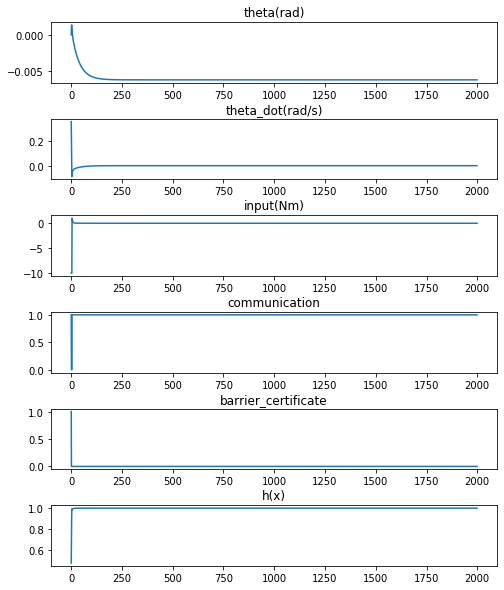

In [35]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication', 'barrier_certificate', 'h(x)'] 
history = a.data_log[0]
x_axis = range(episode_step)
plt.figure(figsize=(8,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(6):
    data = history[:,i]
    plt.subplot(6,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [11]:
a.save_weights('../learned_models_stab/300000_e2000_l05.h5')

(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

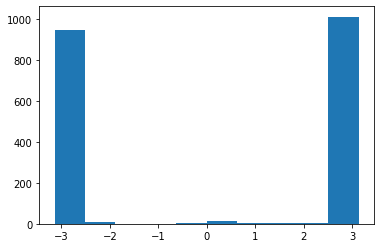

In [11]:
plt.hist(history[:,0])

In [22]:
import csv

with open("../csv/learning_log_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in a.cbf_log:
        writer.writerow(row)

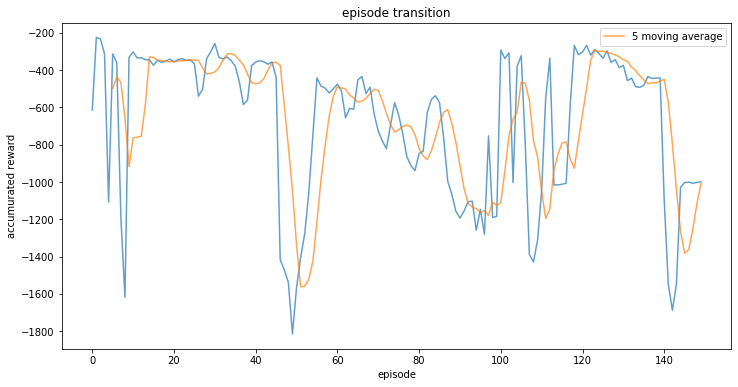

In [36]:
l = 5
plt.figure(figsize=(12,6))
ma = moving_average(a.episode_rewards, l)
plt.plot(range(len(a.episode_rewards)), a.episode_rewards, alpha=0.7)
plt.plot(range(l, len(a.episode_rewards)), ma, label=f'{l} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumurated reward')
plt.title('episode transition')
plt.legend()
plt.show()

In [44]:
rewards = np.array(a.episode_rewards)
import csv

with open("../csv/episode_rewards_pure.csv", "w") as f:
    writer = csv.writer(f)
    for row in rewards:
        writer.writerow([row])

In [41]:
print(a.actor.layers[3].get_weights())

[array([[-6.28152  , -2.2830741,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,